In [1]:
import yfinance as yf
import polars as pl
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import polars.selectors as cs
from sklearn.cluster import KMeans
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

## Dataframe of Mexican Stocks

In [2]:
mexican_stocks =  [
            # Financial Sector (Peso GFNORTE, BBVA, Santander, Inbursa)
            'GFNORTEO.MX',    # Grupo Financiero Banorte - Leading Mexican bank
            'GFINBURO.MX',    # Grupo Financiero Inbursa - Carlos Slim's bank
            
            # Retail & Consumer Staples
            'WALMEX.MX',      # Wal-Mart de México - Largest retailer
            'BIMBOA.MX',      # Grupo Bimbo - Global bakery leader
            'FEMSAUBD.MX',     # Fomento Económico Mexicano - FEMSA conglomerate
            'KOFUBL.MX',      # Coca-Cola FEMSA - Largest Coke bottler in LatAm
            'AC.MX',          # Arca Continental - Coca-Cola bottler
            'LIVEPOL1.MX',    # Liverpool - Premium department stores
            
            # Telecommunications & Media
            'TLEVISACPO.MX',  # Grupo Televisa - Media conglomerate
            
            # Materials & Mining (Commodity Exposure)
            'CEMEXCPO.MX',    # Cemex - Global cement giant
            'GMEXICOB.MX',    # Grupo México - Mining and transportation
            'PE&OLES.MX',     # Industrias Peñoles - Precious metals
            'ALPEKA.MX',      # Alfa - Industrial conglomerate
            
            # Transportation & Infrastructure
            'GAPB.MX',        # Grupo Aeroportuario del Pacífico - Airport operator
            'OMAB.MX',        # Grupo Aeroportuario del Centro Norte - Airports
            'ASURB.MX',       # Grupo Aeroportuario del Sureste - Airport group
            
            # Real Estate Investment Trusts (FIBRAs)
            'FIBRAMQ12.MX',    # Fibra Mty - Industrial real estate
            
            # Healthcare & Consumer Discretionary
            'LABB.MX',        # Genomma Lab Internacional - Pharma & personal care
            'GCARSOA1.MX',     # Grupo Carso - Retail and industrial conglomerate
            
            # Additional Diversification
            'GRUMAB.MX',      # Grupo Financiero Multiva
        ]

In [3]:
raw_data = yf.download(mexican_stocks, "2020-01-01", "2025-09-05")

/tmp/ipykernel_20239/1666138024.py:1: FutureWarning: YF.download() has changed argument auto_adjust default to True
  raw_data = yf.download(mexican_stocks, "2020-01-01", "2025-09-05")
[*********************100%***********************]  20 of 20 completed


## Inspect data

In [4]:
df = pl.from_pandas(raw_data,include_index=True)

In [5]:
df.head()

Date,"('Close', 'AC.MX')","('Close', 'ALPEKA.MX')","('Close', 'ASURB.MX')","('Close', 'BIMBOA.MX')","('Close', 'CEMEXCPO.MX')","('Close', 'FEMSAUBD.MX')","('Close', 'FIBRAMQ12.MX')","('Close', 'GAPB.MX')","('Close', 'GCARSOA1.MX')","('Close', 'GFINBURO.MX')","('Close', 'GFNORTEO.MX')","('Close', 'GMEXICOB.MX')","('Close', 'GRUMAB.MX')","('Close', 'KOFUBL.MX')","('Close', 'LABB.MX')","('Close', 'LIVEPOL1.MX')","('Close', 'OMAB.MX')","('Close', 'PE&OLES.MX')","('Close', 'TLEVISACPO.MX')","('Close', 'WALMEX.MX')","('High', 'AC.MX')","('High', 'ALPEKA.MX')","('High', 'ASURB.MX')","('High', 'BIMBOA.MX')","('High', 'CEMEXCPO.MX')","('High', 'FEMSAUBD.MX')","('High', 'FIBRAMQ12.MX')","('High', 'GAPB.MX')","('High', 'GCARSOA1.MX')","('High', 'GFINBURO.MX')","('High', 'GFNORTEO.MX')","('High', 'GMEXICOB.MX')","('High', 'GRUMAB.MX')","('High', 'KOFUBL.MX')","('High', 'LABB.MX')","('High', 'LIVEPOL1.MX')",…,"('Open', 'BIMBOA.MX')","('Open', 'CEMEXCPO.MX')","('Open', 'FEMSAUBD.MX')","('Open', 'FIBRAMQ12.MX')","('Open', 'GAPB.MX')","('Open', 'GCARSOA1.MX')","('Open', 'GFINBURO.MX')","('Open', 'GFNORTEO.MX')","('Open', 'GMEXICOB.MX')","('Open', 'GRUMAB.MX')","('Open', 'KOFUBL.MX')","('Open', 'LABB.MX')","('Open', 'LIVEPOL1.MX')","('Open', 'OMAB.MX')","('Open', 'PE&OLES.MX')","('Open', 'TLEVISACPO.MX')","('Open', 'WALMEX.MX')","('Volume', 'AC.MX')","('Volume', 'ALPEKA.MX')","('Volume', 'ASURB.MX')","('Volume', 'BIMBOA.MX')","('Volume', 'CEMEXCPO.MX')","('Volume', 'FEMSAUBD.MX')","('Volume', 'FIBRAMQ12.MX')","('Volume', 'GAPB.MX')","('Volume', 'GCARSOA1.MX')","('Volume', 'GFINBURO.MX')","('Volume', 'GFNORTEO.MX')","('Volume', 'GMEXICOB.MX')","('Volume', 'GRUMAB.MX')","('Volume', 'KOFUBL.MX')","('Volume', 'LABB.MX')","('Volume', 'LIVEPOL1.MX')","('Volume', 'OMAB.MX')","('Volume', 'PE&OLES.MX')","('Volume', 'TLEVISACPO.MX')","('Volume', 'WALMEX.MX')"
datetime[ns],f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,…,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64
2020-01-02 00:00:00,79.559837,20.530781,299.919556,32.104298,7.130874,157.305695,16.432257,177.798721,69.649704,24.143885,75.525696,39.922443,175.35643,92.999603,15.210347,94.058487,105.379745,206.533569,40.213379,49.45311,79.692527,20.69722,301.367228,32.213248,7.250386,158.007757,16.764159,178.126776,70.026751,24.408662,75.752971,40.085179,176.803438,93.43437,15.582911,94.058487,…,31.505066,7.140833,155.814891,15.467864,176.650523,66.812436,22.996511,73.273559,38.775882,175.177776,92.99155,15.226544,94.058487,104.964925,200.42642,39.928241,48.627697,574468,447365,110011,1921093,38630092,1358420,604196,470187,265615,1578452,1980815,2980525,351684,236142,1708608,0,552048,328223,955053,7718655
2020-01-03 00:00:00,80.270134,20.677639,301.392181,32.113373,7.160752,158.917847,16.451044,178.74382,70.055031,24.085043,75.732307,40.018585,177.03569,93.756416,15.218444,94.058487,104.883423,210.751602,40.302486,49.067322,80.387215,21.088842,305.427389,32.213245,7.200589,159.047853,16.626388,179.821723,70.696008,24.222337,76.503682,40.602961,178.527362,93.893292,15.388527,94.058487,…,31.813759,7.100996,157.175679,16.325798,177.228511,69.093568,23.830071,75.07802,39.75229,174.445365,93.072064,15.210344,94.058487,105.150095,206.823428,40.088635,49.390311,602320,1191460,268701,1480200,19123326,1961040,529753,549397,412438,2071305,2689637,3721272,391018,540610,1294244,0,135192,502620,1829673,14207686
2020-01-06 00:00:00,79.969635,20.721699,295.888519,32.254105,7.170711,158.822525,16.451044,177.169907,70.399078,24.261562,75.814949,39.075459,174.847305,93.208931,15.242744,94.058487,103.853798,212.450806,39.620834,49.592182,80.277943,20.85387,299.794743,32.558259,7.19063,159.481247,16.570027,177.845551,70.696004,24.438082,75.91137,40.092567,176.857044,93.490728,15.412829,94.058487,…,31.904551,7.120915,157.721754,16

In [6]:
df.describe()

statistic,Date,"('Close', 'AC.MX')","('Close', 'ALPEKA.MX')","('Close', 'ASURB.MX')","('Close', 'BIMBOA.MX')","('Close', 'CEMEXCPO.MX')","('Close', 'FEMSAUBD.MX')","('Close', 'FIBRAMQ12.MX')","('Close', 'GAPB.MX')","('Close', 'GCARSOA1.MX')","('Close', 'GFINBURO.MX')","('Close', 'GFNORTEO.MX')","('Close', 'GMEXICOB.MX')","('Close', 'GRUMAB.MX')","('Close', 'KOFUBL.MX')","('Close', 'LABB.MX')","('Close', 'LIVEPOL1.MX')","('Close', 'OMAB.MX')","('Close', 'PE&OLES.MX')","('Close', 'TLEVISACPO.MX')","('Close', 'WALMEX.MX')","('High', 'AC.MX')","('High', 'ALPEKA.MX')","('High', 'ASURB.MX')","('High', 'BIMBOA.MX')","('High', 'CEMEXCPO.MX')","('High', 'FEMSAUBD.MX')","('High', 'FIBRAMQ12.MX')","('High', 'GAPB.MX')","('High', 'GCARSOA1.MX')","('High', 'GFINBURO.MX')","('High', 'GFNORTEO.MX')","('High', 'GMEXICOB.MX')","('High', 'GRUMAB.MX')","('High', 'KOFUBL.MX')","('High', 'LABB.MX')",…,"('Open', 'BIMBOA.MX')","('Open', 'CEMEXCPO.MX')","('Open', 'FEMSAUBD.MX')","('Open', 'FIBRAMQ12.MX')","('Open', 'GAPB.MX')","('Open', 'GCARSOA1.MX')","('Open', 'GFINBURO.MX')","('Open', 'GFNORTEO.MX')","('Open', 'GMEXICOB.MX')","('Open', 'GRUMAB.MX')","('Open', 'KOFUBL.MX')","('Open', 'LABB.MX')","('Open', 'LIVEPOL1.MX')","('Open', 'OMAB.MX')","('Open', 'PE&OLES.MX')","('Open', 'TLEVISACPO.MX')","('Open', 'WALMEX.MX')","('Volume', 'AC.MX')","('Volume', 'ALPEKA.MX')","('Volume', 'ASURB.MX')","('Volume', 'BIMBOA.MX')","('Volume', 'CEMEXCPO.MX')","('Volume', 'FEMSAUBD.MX')","('Volume', 'FIBRAMQ12.MX')","('Volume', 'GAPB.MX')","('Volume', 'GCARSOA1.MX')","('Volume', 'GFINBURO.MX')","('Volume', 'GFNORTEO.MX')","('Volume', 'GMEXICOB.MX')","('Volume', 'GRUMAB.MX')","('Volume', 'KOFUBL.MX')","('Volume', 'LABB.MX')","('Volume', 'LIVEPOL1.MX')","('Volume', 'OMAB.MX')","('Volume', 'PE&OLES.MX')","('Volume', 'TLEVISACPO.MX')","('Volume', 'WALMEX.MX')"
str,str,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,…,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
"""count""","""1430""",1430.0,1430.0,1430.0,1430.0,1430.0,1430.0,1430.0,1430.0,1430.0,1430.0,1430.0,1430.0,1430.0,1430.0,1430.0,1430.0,1430.0,1430.0,1430.0,1430.0,1430.0,1430.0,1430.0,1430.0,1430.0,1430.0,1430.0,1430.0,1430.0,1430.0,1430.0,1430.0,1430.0,1430.0,1430.0,…,1430.0,1430.0,1430.0,1430.0,1430.0,1430.0,1430.0,1430.0,1430.0,1430.0,1430.0,1430.0,1430.0,1430.0,1430.0,1430.0,1430.0,1430.0,1430.0,1430.0,1430.0,1430.0,1430.0,1430.0,1430.0,1430.0,1430.0,1430.0,1430.0,1430.0,1430.0,1430.0,1430.0,1430.0,1430.0,1430.0,1430.0
"""null_count""","""0""",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,…,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
"""mean""","""2022-11-02 11:22:44.475524""",133.077755,17.994805,390.443375,58.955793,11.181512,158.032545,22.877231,246.788021,90.042213,33.15514,108.399666,76.608578,262.779651,120.942253,16.99503,94.321274,134.161375,274.037477,22.127275,60.569559,134.768703,18.289316,396.210007,59.920079,11.362628,159.924597,23.199358,250.649091,91.831819,33.734802,109.934453,77.890752,266.367327,122.351705,17.308435,…,58.980796,11.178793,158.176028,22.907025,246.782415,90.022425,33.139765,108.317377,76.598504,262.593377,121.02222,17.006883,94.322492,134.155859,273.974836,22.168118,60.576025,1.7134e6,1.6397e6,481850.506294,2.5564e6,3.7907e7,2.8189e6,1.0060e6,1.0329e6,434879.384615,2.4765e6,6.9452e6,6.6645e6,620684.353147,725449.906993,2.9294e6,1792.09021,975581.640559,350323.729371,3.7878e6,1.7377e7
"""std""",null,40.593772,5.914531,111.449364,17.89165,3.004219,30.10637,5.663848,82.321093,36.082524,12.013141,32.622694,20.651706,57.207806,34.070625,3.627901,22.573931,46.164096,77.439862,12.960637,6.737715,41

## Basic Filtering and Grouping

In [7]:
df.columns

['Date',
 "('Close', 'AC.MX')",
 "('Close', 'ALPEKA.MX')",
 "('Close', 'ASURB.MX')",
 "('Close', 'BIMBOA.MX')",
 "('Close', 'CEMEXCPO.MX')",
 "('Close', 'FEMSAUBD.MX')",
 "('Close', 'FIBRAMQ12.MX')",
 "('Close', 'GAPB.MX')",
 "('Close', 'GCARSOA1.MX')",
 "('Close', 'GFINBURO.MX')",
 "('Close', 'GFNORTEO.MX')",
 "('Close', 'GMEXICOB.MX')",
 "('Close', 'GRUMAB.MX')",
 "('Close', 'KOFUBL.MX')",
 "('Close', 'LABB.MX')",
 "('Close', 'LIVEPOL1.MX')",
 "('Close', 'OMAB.MX')",
 "('Close', 'PE&OLES.MX')",
 "('Close', 'TLEVISACPO.MX')",
 "('Close', 'WALMEX.MX')",
 "('High', 'AC.MX')",
 "('High', 'ALPEKA.MX')",
 "('High', 'ASURB.MX')",
 "('High', 'BIMBOA.MX')",
 "('High', 'CEMEXCPO.MX')",
 "('High', 'FEMSAUBD.MX')",
 "('High', 'FIBRAMQ12.MX')",
 "('High', 'GAPB.MX')",
 "('High', 'GCARSOA1.MX')",
 "('High', 'GFINBURO.MX')",
 "('High', 'GFNORTEO.MX')",
 "('High', 'GMEXICOB.MX')",
 "('High', 'GRUMAB.MX')",
 "('High', 'KOFUBL.MX')",
 "('High', 'LABB.MX')",
 "('High', 'LIVEPOL1.MX')",
 "('High', 'OMAB

In [8]:
## Only keep the 'Close' prices
df  = df.select(
    pl.col('Date'),
    cs.starts_with("('Close'").name.map(lambda col_name: col_name.split("', '")[1].rstrip("')"))
)

In [9]:
df.head()


Date,AC.MX,ALPEKA.MX,ASURB.MX,BIMBOA.MX,CEMEXCPO.MX,FEMSAUBD.MX,FIBRAMQ12.MX,GAPB.MX,GCARSOA1.MX,GFINBURO.MX,GFNORTEO.MX,GMEXICOB.MX,GRUMAB.MX,KOFUBL.MX,LABB.MX,LIVEPOL1.MX,OMAB.MX,PE&OLES.MX,TLEVISACPO.MX,WALMEX.MX
datetime[ns],f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
2020-01-02 00:00:00,79.559837,20.530781,299.919556,32.104298,7.130874,157.305695,16.432257,177.798721,69.649704,24.143885,75.525696,39.922443,175.35643,92.999603,15.210347,94.058487,105.379745,206.533569,40.213379,49.45311
2020-01-03 00:00:00,80.270134,20.677639,301.392181,32.113373,7.160752,158.917847,16.451044,178.74382,70.055031,24.085043,75.732307,40.018585,177.03569,93.756416,15.218444,94.058487,104.883423,210.751602,40.302486,49.067322
2020-01-06 00:00:00,79.969635,20.721699,295.888519,32.254105,7.170711,158.822525,16.451044,177.169907,70.399078,24.261562,75.814949,39.075459,174.847305,93.208931,15.242744,94.058487,103.853798,212.450806,39.620834,49.592182
2020-01-07 00:00:00,80.722839,20.403502,299.154114,31.822838,7.04124,160.053299,16.094095,178.470444,69.140694,23.751617,73.611031,39.16053,172.909027,92.862732,15.307539,94.058487,102.913017,212.130951,38.841152,49.327507
2020-01-08 00:00:00,80.457474,20.413298,302.165955,31.795607,7.170711,159.099854,15.987638,183.336624,69.668549,23.643747,74.919617,40.210918,176.694443,92.43602,15.153654,94.058487,104.446388,209.901993,39.26886,49.982452


In [10]:
df.tail()

Date,AC.MX,ALPEKA.MX,ASURB.MX,BIMBOA.MX,CEMEXCPO.MX,FEMSAUBD.MX,FIBRAMQ12.MX,GAPB.MX,GCARSOA1.MX,GFINBURO.MX,GFNORTEO.MX,GMEXICOB.MX,GRUMAB.MX,KOFUBL.MX,LABB.MX,LIVEPOL1.MX,OMAB.MX,PE&OLES.MX,TLEVISACPO.MX,WALMEX.MX
datetime[ns],f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
2025-08-29 00:00:00,190.710007,8.8,607.02002,58.080002,16.92,161.899994,31.299999,447.160004,124.099998,49.080002,170.009995,121.176781,320.859985,158.210007,22.32,102.0,237.800003,605.719971,10.34,55.759998
2025-09-01 00:00:00,194.899994,8.7,609.580017,57.830002,16.700001,163.899994,31.690001,452.589996,124.650002,50.740002,168.75,122.03788,326.640015,159.600006,22.450001,102.0,241.410004,610.0,10.31,56.09
2025-09-02 00:00:00,192.509995,8.72,618.109985,59.419998,17.15,162.139999,31.559999,455.410004,127.870003,50.990002,173.75,123.294876,326.98999,157.350006,23.049999,102.0,242.619995,655.070007,10.53,56.860001
2025-09-03 00:00:00,190.880005,8.57,618.340027,60.139999,17.17,156.479996,31.450001,452.5,124.550003,50.720001,172.190002,125.700005,327.670013,151.789993,22.389999,102.0,238.330002,718.200012,10.51,55.939999
2025-09-04 00:00:00,192.809998,8.53,629.0,61.279999,17.34,160.009995,31.700001,462.619995,128.350006,50.84,172.660004,126.800003,329.899994,156.289993,22.42,102.0,241.220001,692.73999,10.65,56.310001


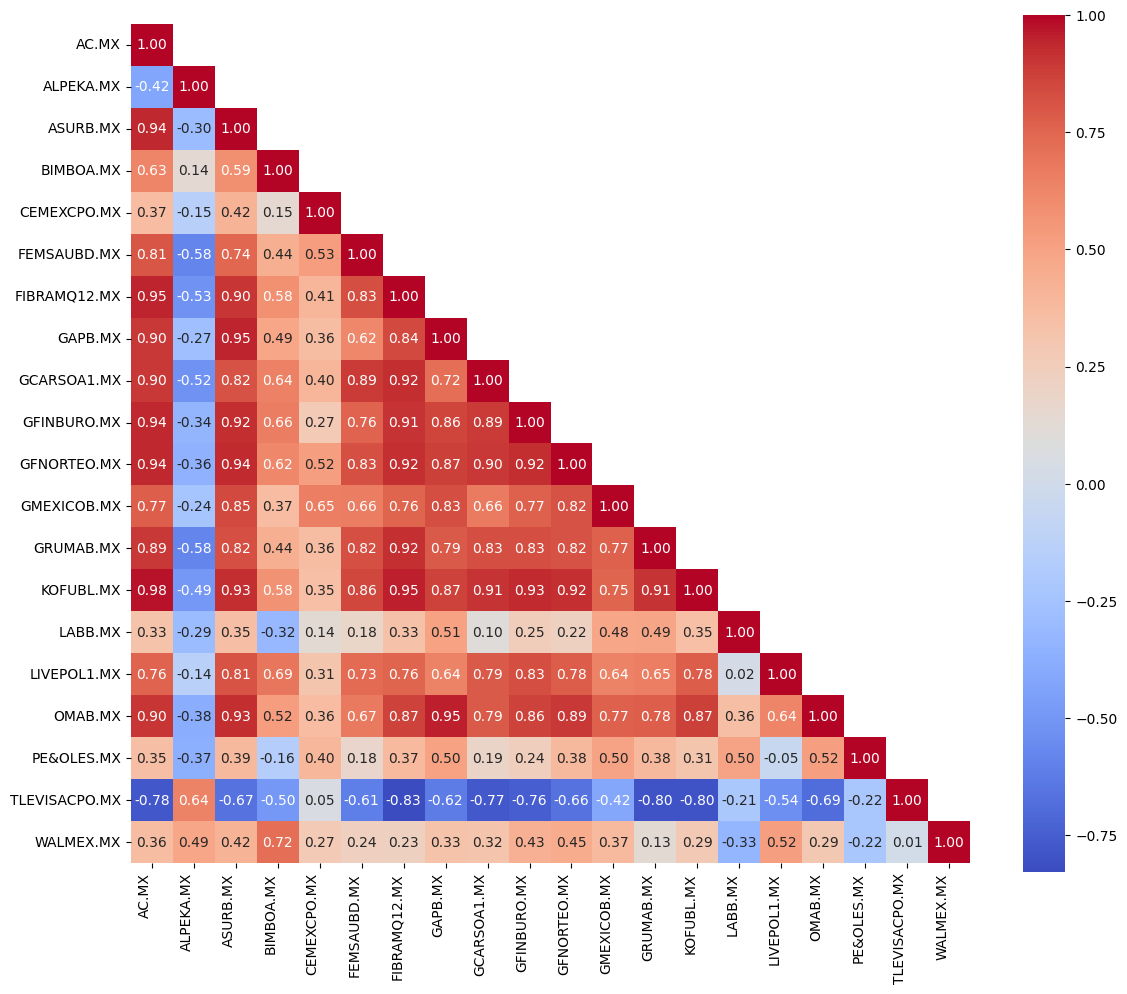

In [11]:
corr_matrix = df.select(df.columns[1:]).corr()
mask = np.triu(np.ones_like(corr_matrix), k=1)

plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, 
            mask=mask, 
            annot=True, 
            fmt=".2f", 
            cmap="coolwarm",
            square=True)
plt.xticks(rotation=90, ha='right',ticks=np.arange(len(corr_matrix.columns))+0.5, labels=corr_matrix.columns)
plt.yticks(rotation=0, ticks=np.arange(len(corr_matrix.columns))+0.5, labels=corr_matrix.columns)
plt.tight_layout()

Text(0.5, 1.0, 'Elbow Method for Optimal k')

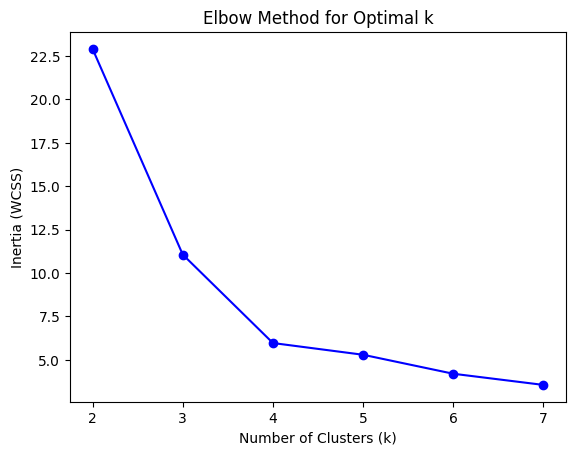

In [12]:
inertias = []
for k in range(2, 8):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(corr_matrix)
    inertias.append(kmeans.inertia_)

plt.plot(range(2, 8), inertias, 'bo-')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia (WCSS)')
plt.title('Elbow Method for Optimal k')

In [13]:
# From the elbow plot, we choose k=4
kmeans = KMeans(n_clusters=4, random_state=42)
kmeans.fit(corr_matrix)

,n_clusters,4
,init,'k-means++'
,n_init,'auto'
,max_iter,300
,tol,0.0001
,verbose,0
,random_state,42
,copy_x,True
,algorithm,'lloyd'


In [14]:
cluster_groups = {}
for stock, cluster in zip(corr_matrix.columns, kmeans.labels_):
    if cluster not in cluster_groups:
        cluster_groups[cluster] = []
    cluster_groups[cluster].append(stock)

# Create a more readable format
print("Mexican Stock Correlation Clusters")
print("=" * 50)
for cluster_id in sorted(cluster_groups.keys()):
    print(f"\nCluster {cluster_id} ({len(cluster_groups[cluster_id])} stocks):")
    print("-" * 30)
    for stock in sorted(cluster_groups[cluster_id]):
        print(f"  • {stock}")

Mexican Stock Correlation Clusters

Cluster 0 (13 stocks):
------------------------------
  • AC.MX
  • ASURB.MX
  • FEMSAUBD.MX
  • FIBRAMQ12.MX
  • GAPB.MX
  • GCARSOA1.MX
  • GFINBURO.MX
  • GFNORTEO.MX
  • GMEXICOB.MX
  • GRUMAB.MX
  • KOFUBL.MX
  • LIVEPOL1.MX
  • OMAB.MX

Cluster 1 (2 stocks):
------------------------------
  • ALPEKA.MX
  • TLEVISACPO.MX

Cluster 2 (2 stocks):
------------------------------
  • BIMBOA.MX
  • WALMEX.MX

Cluster 3 (3 stocks):
------------------------------
  • CEMEXCPO.MX
  • LABB.MX
  • PE&OLES.MX


## Forecasting Cluster 2 (Consumer Staples - 2 stocks): BIMBOA.MX (Grupo Bimbo - food) + WALMEX.MX (Walmart México - retail)

In [15]:
#It is usually better to model returns than prices
df_returns = df.select([
    pl.col('Date'),
    (pl.col('WALMEX.MX').pct_change()).alias('WALMEX_returns'),
    (pl.col('BIMBOA.MX').pct_change()).alias('BIMBOA_returns')
]).drop_nulls()

In [16]:
df_returns

Date,WALMEX_returns,BIMBOA_returns
datetime[ns],f64,f64
2020-01-03 00:00:00,-0.007801,0.000283
2020-01-06 00:00:00,0.010697,0.004382
2020-01-07 00:00:00,-0.005337,-0.013371
2020-01-08 00:00:00,0.013277,-0.000856
2020-01-09 00:00:00,-0.002513,0.023129
…,…,…
2025-08-29 00:00:00,0.002878,0.000689
2025-09-01 00:00:00,0.005918,-0.004304
2025-09-02 00:00:00,0.013728,0.027494


Text(0, 0.5, 'Price (MXN)')

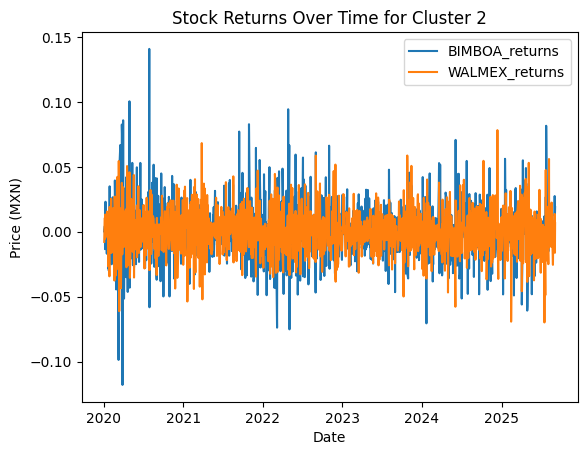

In [17]:
sns.lineplot(data=df_returns, x='Date', y='BIMBOA_returns', label='BIMBOA_returns')
sns.lineplot(data=df_returns, x='Date', y='WALMEX_returns', label='WALMEX_returns')
plt.title('Stock Returns Over Time for Cluster 2')
plt.xlabel('Date')
plt.ylabel('Price (MXN)')

In [18]:
# Create train/test split (last 30 days for testing)
n_test = 30
n_train = len(df) - n_test

# Extract data using Polars syntax
X_train = df_returns['WALMEX_returns'][:n_train].to_numpy().reshape(-1, 1)
y_train = df_returns['BIMBOA_returns'][:n_train].to_numpy()

X_test = df_returns['WALMEX_returns'][n_train:].to_numpy().reshape(-1, 1)
y_test = df_returns['BIMBOA_returns'][n_train:].to_numpy()

# Fit model
stock_model = LinearRegression()
stock_model.fit(X_train, y_train)

# Predictions
y_pred = stock_model.predict(X_test)

# Metrics
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Predicting BIMBOA using WALMEX:")
print(f"MSE: {mse:.2f}")
print(f"R²: {r2:.2f}")
print(f"Equation: BIMBOA = {stock_model.coef_[0]:.3f} * WALMEX + {stock_model.intercept_:.3f}")

Predicting BIMBOA using WALMEX:
MSE: 0.00
R²: 0.16
Equation: BIMBOA = 0.270 * WALMEX + 0.001
